## ResNet
只有当较复杂的函数类包含较小的函数类时才能确保提高它们的性能。
对于深度神经网络，如果能将新添加的层训练成恒等映射f(x)=x，新模型和原模型将同样有效。 
同时，由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。
残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

ResNet沿用了VGG完整的$3\times 3$卷积层设计。
残差块里首先有2个有相同输出通道数的$3\times 3$卷积层。
每个卷积层后接一个批量规范化层和ReLU激活函数。
然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。
这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。
如果想改变通道数，就需要引入一个额外的$1\times 1$卷积层来将输入变换成需要的形状后再做相加运算。

In [16]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [17]:
# 输入输出一致
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [23]:
# 可调整网络参数控制输出情况
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

ResNet的前两层跟之前介绍的GoogLeNet中的一样：
在输出通道数为64、步幅为2的$7 \times 7$卷积层后，接步幅为2的$3 \times 3$的最大汇聚层。
不同之处在于ResNet每个卷积层后增加了批量规范化层。

In [24]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet在后面接了4个由Inception块组成的模块。
ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。
第一个模块的通道数同输入通道数一致。
由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。
之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。
需要对第一个模块做特别处理。

In [29]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        # b2块不需要执行stride=2，其余都需要在块的第一层先高宽减半
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

每个模块有4个卷积层（不包括恒等映射的$1\times 1$卷积层）。
加上第一个$7\times 7$卷积层和最后一个全连接层，共有18层。
因此，这种模型通常被称为ResNet-18。

In [30]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [31]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [32]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.014, train acc 0.996, test acc 0.920
6375.9 examples/sec on cuda:0


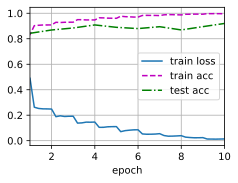

In [33]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())